In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model

/home/michael/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Loading in datasets

#### (a) Dataset for Credit Default Swap spreads

In [2]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


#### (b) Dataset for equities of different companies

In [3]:
comp_stocks_DF = pd.read_csv("datasets/company_stock_data.csv", index_col='Date', parse_dates=True)
comp_stocks_DF.head()

,A,AAPL,ABBV,ABT,ADM,ADP,AES,AFG,AGR,AIG,...,WEC,WELL,WFC,WHR,WM,WMB,WMT,WU,WY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.422062,24.347172,43.563179,37.108746,39.133045,67.362991,9.684173,30.017288,NaN,44.253033,...,38.417412,51.027782,41.032391,135.059799,42.477646,25.322723,23.493425,11.352100,24.284630,60.042534
2015-01-05,36.720852,23.661274,42.743362,37.117004,37.778957,67.314476,9.408492,29.623707,NaN,43.377602,...,37.947937,51.657738,39.907192,132.274841,42.050804,24.320345,23.425055,11.244470,24.284630,58.399651
2015-01-06,36.148819,23.663500,42.531784,36.695503,37.034214,66.756416,9.196430,29.454308,NaN,42.762428,...,38.049053,52.393814,39.074547,131.183243,42.083641,23.989943,23.605558,11.225472,24.257740,58.089199
2015-01-07,36.628582,23.995317,44.250786,36.993034,37.590893,67.338745,9.210567,29.648619,NaN,42.967476,...,38.518543,52.877903,39.307091,134.269150,42.116470,23.861147,24.231873,11.117839,24.331717,58.677792
2015-01-08,37.726505,24.917271,44.713577,37.753399,37.041733,68.883507,9.351940,30.186687,NaN,42.778191,...,38.944660,52.659077,40.177235,137.732925,42.600754,24.090736,24.743311,11.339439,24.593996,59.654469


#### (c) Dataset for total asset value and total debt vale of companies

In [4]:
quarterly_DF = pd.read_csv("datasets/quarterly_company_data.csv", parse_dates=['datadate'])
quarterly_DF.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,cusip,...,costat,dvpspq,dvpsxq,mkvaltq,gind,gsector,gsubind,idbflag,naics,spcsrc
0,1078,2014-12-31,2014,4.0,INDL,C,D,STD,ABT,002824100,...,A,0.22,0.22,67891.7357,351010.0,35.0,35101010.0,B,334510,B+
1,1078,2015-03-31,2015,1.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,68974.1118,351010.0,35.0,35101010.0,B,334510,B+
2,1078,2015-06-30,2015,2.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,73150.8443,351010.0,35.0,35101010.0,B,334510,B+
3,1078,2015-09-30,2015,3.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,59996.9784,351010.0,35.0,35101010.0,B,334510,B+
4,1078,2015-12-31,2015,4.0,INDL,C,D,STD,ABT,002824100,...,A,0.24,0.24,66137.3852,351010.0,35.0,35101010.0,B,334510,B+


#### (d) risk free rate series

In [5]:
risk_free_rate_S = web.DataReader('TB3MS', 'fred', start=quarterly_DF['datadate'].min().strftime('%Y-%m-%d'), 
                                  end=quarterly_DF['datadate'].max().strftime('%Y-%m-%d'))

## 2. Processing data

In [6]:
def create_correct_dataframe(comp_tick):
    """This function will given an ticker name of a company create a dataframe that is necessary for the
    implied CDS-spread model. The only prerequisite is that the above code is run and hence the right
    .csv files are loaded in"""
    #fetch quarterly comp data for atq and ltq
    temp_comp_quarter = quarterly_DF[quarterly_DF['tic'] == comp_tick][['datadate','atq','ltq','cshoq']]

    #create a date range of comp data in days
    quart_to_days = pd.date_range(start=temp_comp_quarter['datadate'].min(), end=temp_comp_quarter['datadate'].max())
    
    #set the previously made date range as index
    temp_comp_quarter = temp_comp_quarter.set_index('datadate').reindex(quart_to_days).reset_index(names='datadate')

    #interpolate for the NaN values in lineair fashion
    temp_comp_quarter = temp_comp_quarter.interpolate(method='linear', limit_direction='forward', axis=0).set_index('datadate')

    #load equity data of company ticker
    temp_comp_equity = comp_stocks_DF[comp_tick]
    
    #combine the datasets on same dates
    temp_comp_comb = pd.merge(temp_comp_quarter, temp_comp_equity, left_index=True, right_index=True)

    #add column for log returns for both equity and total asset values
    temp_comp_comb['log_returns_eq'] = np.log(temp_comp_comb[comp_tick] / temp_comp_comb[comp_tick].shift(1))
    temp_comp_comb['log_returns_as'] = np.log(temp_comp_comb['atq'] / temp_comp_comb['atq'].shift(1))*100 #This I dont know about

    #Add the actual CDS data
    temp_comp_CDS = cds_DF[cds_DF['Ticker'] == comp_tick][['Date', 'PX1', 'PX2', 'PX3', 'PX4', 'PX5', 'PX6', 'PX7', 'PX8', 'PX9', 'PX10']].set_index('Date')
    temp_comp_comb = pd.merge(temp_comp_comb, temp_comp_CDS, left_index=True, right_index=True)

    #Add the riskfree rate data
    temp_comp_comb['rfree'] = risk_free_rate_S.reindex(temp_comp_comb.index, method='bfill')

    return temp_comp_comb

#example usage
create_correct_dataframe('AAPL').head()

,atq,ltq,cshoq,AAPL,log_returns_eq,log_returns_as,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10,rfree
2015-01-02,261878.444444,138424.266667,5824.993644,24.347172,NaN,NaN,8.300,11.100,12.900,16.800,23.600,31.805,36.705,42.800,47.605,51.60,0.02
2015-01-05,261855.111111,138211.666667,5822.855611,23.661274,-0.028576,-0.00891,9.535,12.800,14.890,19.415,27.290,36.520,41.860,48.455,53.560,57.77,0.02
2015-01-06,261847.333333,138140.800000,5822.142933,23.663500,0.000094,-0.00297,7.820,10.455,12.145,15.815,22.225,30.110,34.905,40.905,45.670,49.67,0.02
2015-01-07,261839.555556,138069.933333,5821.430256,23.995317,0.013925,-0.00297,7.835,10.475,12.175,15.860,22.300,30.220,35.035,41.065,45.850,49.86,0.02
2015-01-08,261831.777778,137999.066667,5820.717578,24.917271,0.037702,-0.00297,7.805,10.440,12.130,15.800,22.215,30.115,34.910,40.920,45.695,49.70,0.02


In [7]:
#load all used ticker names in a list.
with open('datasets/tickers.txt', 'r') as ticks:
    tickers = ticks.read().split('\n')[:-1]

In [8]:
#create a dictionary with ticker names and corresponding dataframe created by create_correct_dataframe()
ticks_DF_dict = {}
for tick in tickers:
    temp_cds_data = cds_DF[cds_DF['Ticker'] == tick].set_index('Date')
    temp_comp_equity = comp_stocks_DF[tick].rename("equity")

    temp_comp_comb = pd.merge(temp_cds_data, temp_comp_equity, left_index=True, right_index=True)
    
    ticks_DF_dict[tick] = temp_comp_comb

## 3. Trying some predictions based on Fourier analysis

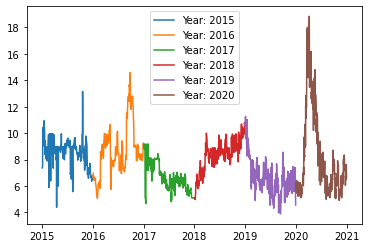

In [9]:
for year in range(15,21):
    plt.plot(ticks_DF_dict['MCD'][ticks_DF_dict['MCD'].index.year == 2000+year]['PX1'], label=f'Year: {2000+year}')

plt.legend();

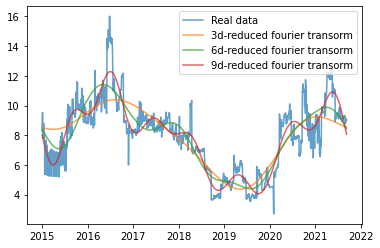

In [10]:
PX1_fft = np.fft.fft(np.asarray(ticks_DF_dict['AAPL']['PX1'].tolist()))
#plt.plot(ticks_DF_dict['AAPL'].index, PX1_fft)
plt.plot(ticks_DF_dict['AAPL']['PX1'], alpha=0.7, label='Real data')

for i in range(3,10,3):
    reduced_transform = PX1_fft.copy()
    reduced_transform[i:-i] = 0
    
    plt.plot(ticks_DF_dict['AAPL']['PX1'].index, np.fft.ifft(reduced_transform).real, alpha=0.7, label=f"{i}d-reduced fourier transorm")
    
plt.legend();

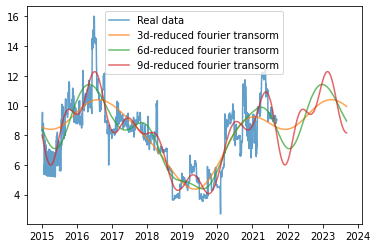

In [11]:
PX1_fft = np.fft.fft(np.asarray(ticks_DF_dict['AAPL']['PX1'].tolist()))
#plt.plot(ticks_DF_dict['AAPL'].index, PX1_fft)
plt.plot(ticks_DF_dict['AAPL']['PX1'], alpha=0.7, label='Real data')

original_index = ticks_DF_dict['AAPL']['PX1'].index

# Extended index for the next year
new_dates = pd.date_range(
    start=original_index[-1] + pd.Timedelta(days=1),  # Start from the next day
    end=original_index[-1] + pd.DateOffset(years=2),  # Extend by 1 year
    freq='B'  # Business days
)
extended_index = original_index.union(new_dates)

# Generate a periodic function mapped to extended DateTimeIndex
def generate_periodic_function(fft_object, freqs, time_points, num_components=None):
    """
    Generate a periodic function from an FFT object.

    Args:
        fft_object: Fourier transform (complex coefficients).
        freqs: Frequencies corresponding to the FFT object.
        time_points: Time points (e.g., days since start) to evaluate the function.
        num_components: Number of frequency components to include (for smoothing).

    Returns:
        A numpy array representing the periodic function.
    """
    # Limit to num_components frequencies (low frequencies capture main structure)
    if num_components:
        fft_object = fft_object.copy()
        fft_object[num_components:-num_components] = 0

    # Reconstruct the signal as a sum of sinusoids
    reconstructed_signal = np.zeros_like(time_points, dtype=np.float64)
    for k, freq in enumerate(freqs):
        amplitude = np.abs(fft_object[k]) / len(fft_object)
        phase = np.angle(fft_object[k])
        reconstructed_signal += amplitude * np.cos(2 * np.pi * freq * time_points + phase)

    return reconstructed_signal

# Map extended index to time points (days since start)
time_points = np.arange(len(extended_index))  # Treat as numerical points for the FFT

for i in range(3,10,3):
    periodic_function = generate_periodic_function(PX1_fft, np.fft.fftfreq(len(original_index)), time_points, num_components=i)
    
    plt.plot(extended_index, periodic_function, alpha=0.7, label=f"{i}d-reduced fourier transorm")

plt.legend();

### Trying models based on ARIMA

In [12]:
import pmdarima as pm

In [13]:
apple_DF = ticks_DF_dict['AAPL']['PX1']

train_set, test_set= np.split(apple_DF, [int(.8 *len(apple_DF))])
print(train_set)

Date
2015-01-02    8.3000
2015-01-05    9.5350
2015-01-06    7.8200
2015-01-07    7.8350
2015-01-08    7.8050
               ...  
2020-05-05    9.2280
2020-05-06    9.2554
2020-05-07    9.4696
2020-05-08    9.5023
2020-05-11    9.3198
Name: PX1, Length: 1348, dtype: float64


/home/michael/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


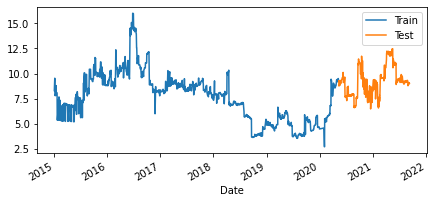

In [14]:
fig, ax = plt.subplots(figsize=(7, 3))
train_set.plot(ax=ax, label = "Train")
test_set.plot(ax=ax, label = "Test")
ax.legend()

In [15]:
arima = pm.AutoARIMA(seasonal = False)
modelfit = arima.fit(train_set)
print(modelfit.summary())
# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(test_set))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1348
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -925.498
Date:                Thu, 05 Dec 2024   AIC                           1856.997
Time:                        12:10:15   BIC                           1872.613
Sample:                             0   HQIC                          1862.846
                               - 1348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4133      0.048      8.539      0.000       0.318       0.508
ma.L1         -0.6706      0.044    -15.316      0.000      -0.756      -0.585
sigma2         0.2313      0.003     73.166      0.0

/home/michael/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/michael/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
print(arima_test)

1348    9.335939
1349    9.342610
1350    9.345367
1351    9.346507
1352    9.346978
          ...   
1680    9.347310
1681    9.347310
1682    9.347310
1683    9.347310
1684    9.347310
Length: 337, dtype: float64


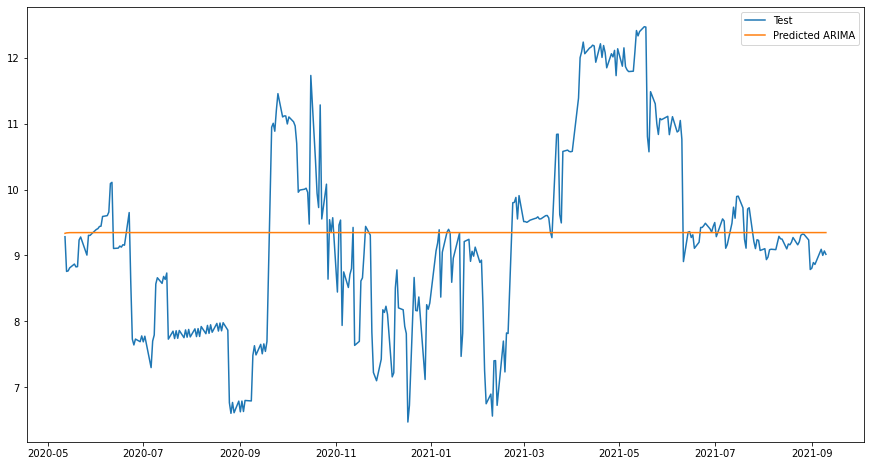

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(test_set, label = "Test")
ax.plot(test_set.index, arima_test, label = 'Predicted ARIMA')
ax.legend()
plt.show()

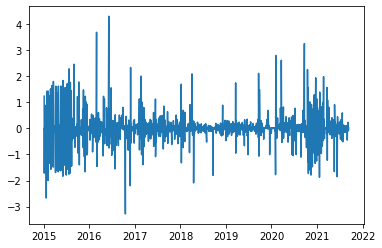

In [18]:
plt.plot(apple_DF-apple_DF.shift(1));

(array([  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,
          1.,   1.,   5.,   5.,   3.,   9.,  10.,   6.,  17.,  11.,  29.,
         48., 101., 211., 559., 331., 124.,  57.,  54.,  26.,  21.,   9.,
          9.,   9.,   5.,   4.,   4.,   2.,   1.,   3.,   1.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-10.26932526,  -9.8676915 ,  -9.46605774,  -9.06442398,
         -8.66279022,  -8.26115646,  -7.85952271,  -7.45788895,
         -7.05625519,  -6.65462143,  -6.25298767,  -5.85135391,
         -5.44972015,  -5.0480864 ,  -4.64645264,  -4.24481888,
         -3.84318512,  -3.44155136,  -3.0399176 ,  -2.63828384,
         -2.23665009,  -1.83501633,  -1.43338257,  -1.03174881,
         -0.63011505,  -0.22848129,   0.17315247,   0.57478622,
          0.97641998,   1.37805374,   1.7796875 ,   2.18132126,
          2.58295502,   2.98458878,   3.38622253,   3.78785629,
          4.18949005,   4.59112381,   4.99275757,   5.39439133,
          5.796025

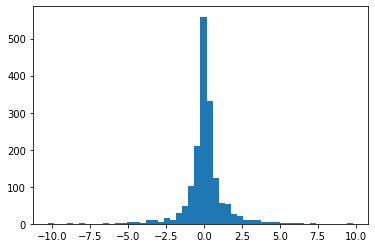

In [19]:
emp_dist_apple = ticks_DF_dict['AAPL']['equity']-ticks_DF_dict['AAPL']['equity'].shift(1)
plt.hist(emp_dist_apple, bins=50)

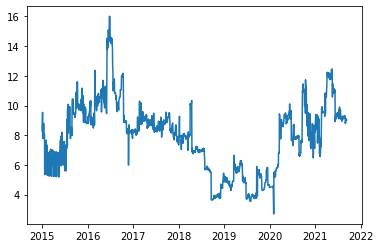

In [20]:
plt.plot(ticks_DF_dict['AAPL']['PX1'])

In [21]:
def simple_predictor(tick, px, years, N):
    boot_emp_dist = np.array((ticks_DF_dict[tick][px] - ticks_DF_dict[tick][px].shift(1)).dropna())
    
    new_dates = pd.date_range(
        start=ticks_DF_dict[tick].index[-1] + pd.Timedelta(days=1),  # Start from the next day
        end=ticks_DF_dict[tick].index[-1] + pd.DateOffset(years=years),  # Extend by 1 year
        freq='B'  # Business days
    )
    
    cols = []
    # Generate all the columns and store them in the list
    for i in range(N):
        rand_boot = np.random.choice(boot_emp_dist, len(new_dates))
        boot_series = ticks_DF_dict[tick].iloc[-1:][px].iloc[0] + np.cumsum(rand_boot)
        cols.append(boot_series)
    
    # Create a DataFrame from the list of columns, using the new dates as index
    bootsDF = pd.DataFrame(cols, index=[f"bcont{i}" for i in range(len(cols))]).T.set_index(new_dates)
    return bootsDF

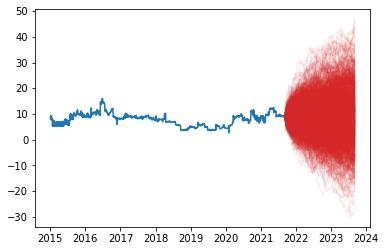

In [22]:
prediction = simple_predictor("AAPL", "PX1", 2, 1000)
plt.plot(ticks_DF_dict['AAPL']['PX1'])
plt.plot(prediction, color="tab:red", alpha=0.1, linewidth=1);

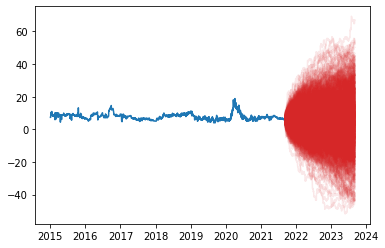

In [23]:
prediction = simple_predictor("MCD", "PX1", 2, 1000)
plt.plot(ticks_DF_dict['MCD']['PX1'])
plt.plot(prediction, color="tab:red", alpha=0.1);

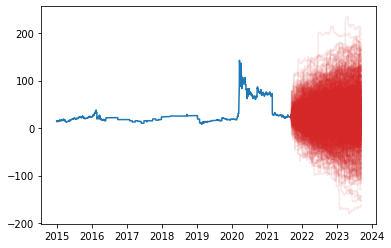

In [24]:
prediction = simple_predictor("A", "PX1", 2, 1000)
plt.plot(ticks_DF_dict['A']['PX1'])
plt.plot(prediction, color="tab:red", alpha=0.1);

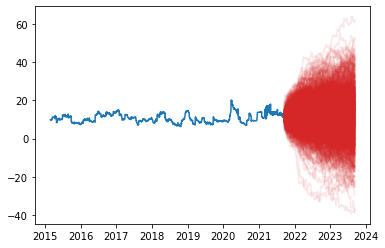

In [25]:
prediction = simple_predictor("AMZN", "PX1", 2, 1000)
plt.plot(ticks_DF_dict['AMZN']['PX1'])
plt.plot(prediction, color="tab:red", alpha=0.1);

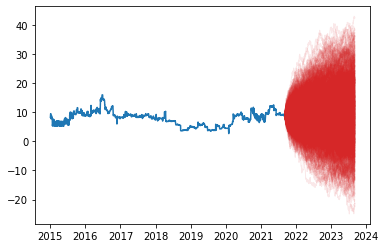

In [26]:
def wiener_process(init_val, steps, var):
    return np.cumsum(np.random.normal(0, var, steps)) + init_val

def more_advanced_predictor(tick, px, years, N):
    boot_emp_dist = np.array((ticks_DF_dict[tick][px] - ticks_DF_dict[tick][px].shift(1)).dropna())
    
    new_dates = pd.date_range(
        start=ticks_DF_dict[tick].index[-1] + pd.Timedelta(days=1),  # Start from the next day
        end=ticks_DF_dict[tick].index[-1] + pd.DateOffset(years=years),  # Extend by 1 year
        freq='B'  # Business days
    )
    
    cols = []
    # Generate all the columns and store them in the list
    for i in range(N):
        cols.append(wiener_process(ticks_DF_dict[tick].iloc[-1:][px].iloc[0], len(new_dates), np.std(boot_emp_dist)))
    
    # Create a DataFrame from the list of columns, using the new dates as index
    bootsDF = pd.DataFrame(cols, index=[f"bcont{i}" for i in range(len(cols))]).T.set_index(new_dates)
    return bootsDF
    
prediction = more_advanced_predictor("AAPL", "PX1", 2, 1000)
plt.plot(ticks_DF_dict['AAPL']['PX1'])
plt.plot(prediction, color="tab:red", alpha=0.1, linewidth=1);
        

## Appendix: Just some testing

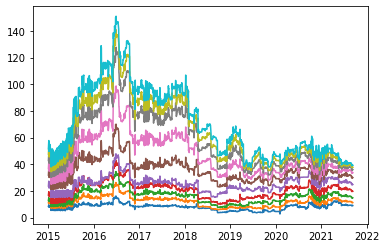

In [27]:
for i in range(1,11):
    plt.plot(ticks_DF_dict['AAPL'].index, ticks_DF_dict['AAPL'][f"PX{i}"])

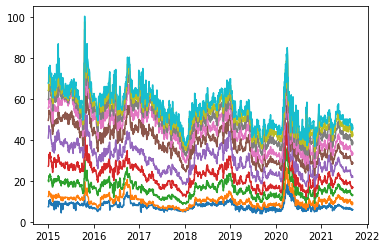

In [28]:
for i in range(1,11):
    plt.plot(ticks_DF_dict['MCD'].index, ticks_DF_dict['MCD'][f"PX{i}"])